# Compare slit profile with reference profile for [O III]

Repeat of previous workbook but for a different line

I first work through all the steps individually, looking at graphs of the intermediate results.  This was used while iterating on the algorithm, by swapping out the value of `db` below for different slits that showed problems.

## First try it out by hand for a single slit

In [1]:
from pathlib import Path
import yaml
import numpy as np
from numpy.polynomial import Chebyshev
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from matplotlib import pyplot as plt
import seaborn as sns

import mes_longslit as mes


In [2]:
dpath = Path.cwd().parent / "data"
pvpath = dpath / "pvextract"
pvpath.mkdir(exist_ok=True)

List of data for each Ha slit exposure:

In [3]:
slit_db_list = yaml.safe_load((dpath / "slits-o3.yml").read_text())

Photometric reference image:

In [4]:
(photom,) = fits.open(dpath / "regrid" / "ha-imslit-median.fits")
wphot = WCS(photom.header)

To start off with, we will analyze a single slit. **This is what we change when we want to try a differnt slit**

In [5]:
db = slit_db_list[3]
db

{'slit_id': 'spm0023o',
 'orig_file': 'crspm0023o_bx-oiii.fits',
 'image_id': 'spm0025o',
 'line_id': 'O III',
 'slit_width': 150,
 'trim': [0, 0, 0, -5],
 'islit': 392,
 'shift_range': [5, 100],
 'jwin': [420, 530],
 'comment': 'Grazes E limb. '}

Get the HDUs for both the slit spectrum and the image+slit. The spectrum file names are very variable, so we have an `orig_file` entry in the database:

In [6]:
spec_hdu = fits.open(dpath / "originals" / db["orig_file"])[0]

But the image file names are more regular and can be derived from the `image_id` entry:

In [7]:
(im_hdu,) = fits.open(dpath / "wcs" / f"cr{db['image_id']}_b-wcs.fits")

There is no sign of any saturated pixels in any of the exposures, so we can miss out that step.

Add in extra fields to database:

- `wa` wavelength axis (1 or 2, fits order) in PV spectrum
- `ij` slit orientation in I+S (1=vertical, 2=horizontal)

In [8]:
if db["slit_id"].startswith("N"):
    db["wa"] = 2
    db["ij"] = 2
else:
    db["wa"] = 1
    db["ij"] = 1
db["s"] = 1

In [9]:
if "cosmic_rays" in db:
    spec_hdu.data = mes.remove_cosmic_rays(
        spec_hdu.data, db["cosmic_rays"], np.nanmedian(spec_hdu.data),
    )

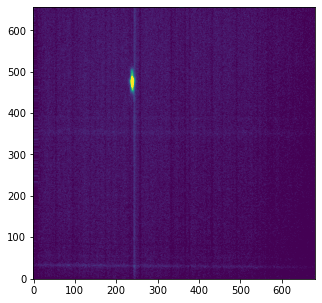

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax.imshow(spec_hdu.data[250:700, :],
#          #vmin=-3, vmax=30,
#          origin="lower");
ax.imshow(spec_hdu.data[:, :], vmin=10, vmax=100, origin="lower")

Try to correct for gradient:

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


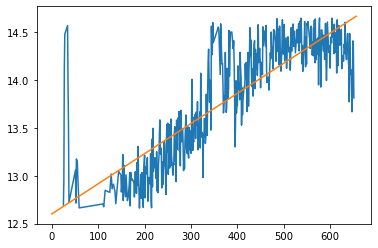

In [11]:
if "trim" in db:
    # Replace non-linear part with NaNs
    spec_hdu.data = mes.trim_edges(spec_hdu.data, db["trim"])
    # Fit and remove the linear trend along slit
    pvmed = np.nanmedian(spec_hdu.data, axis=2 - db["wa"])
    s = np.arange(len(pvmed))
    pvmed0 = np.nanmedian(pvmed)
    sig = np.nanstd(pvmed)
    m = np.abs(pvmed - pvmed0) <= db.get("bg_sig", 1) * sig
    p = Chebyshev.fit(s[m], pvmed[m], db.get("bg_deg", 1))
    if db["wa"] == 1:
        spec_hdu.data -= p(s)[:, None]
    else:
        spec_hdu.data -= p(s)[None, :]
    # And replace the NaNs with the median value
    spec_hdu.data = mes.trim_edges(
        spec_hdu.data, db["trim"], np.nanmedian(spec_hdu.data)
    )

    fig, ax = plt.subplots()
    ax.plot(s[m], pvmed[m])
    ax.plot(s, p(s))

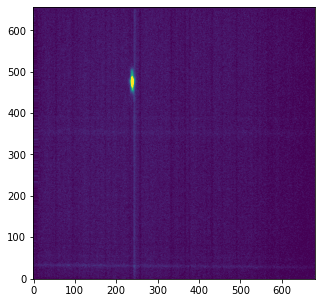

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(spec_hdu.data[:, :], vmin=-5, vmax=100, origin="lower")

So we are no longer attempting to remove the sky at this stage, but we are trying to remove the light leak or whatever it is that adds a bright background at one end of the slit.  This is necessary so that the cross correlation works.

Lines to avoid when calculating the continuum

In [13]:
restwavs = {"oiii": 5006.84, "hei": 5015.68}

In [14]:
spec_profile = mes.extract_full_profile_from_pv(
    spec_hdu,
    wavaxis=db["wa"],
    bandwidth=None,
    linedict=restwavs,
)

This is the position of the slit in pixel coordinates.

In [15]:
imslit_profile = mes.extract_slit_profile_from_imslit(
    im_hdu.data,
    db,
    slit_width=2,
)

392


In [16]:
jslit = np.arange(len(spec_profile))

In [17]:
spec_profile.shape, imslit_profile.shape

((657,), (657,))

In [18]:
spec_profile -= np.median(spec_profile)
imslit_profile -= np.median(imslit_profile)

### Find a better way to do the alignment

I am going to experiment with using cross-correlation to estimate the along-slit offset between `spec_profile` and `imslit_profile`:

In [19]:
ns = len(spec_profile)
assert len(imslit_profile) == ns, "Incompatible lengths"

The above assert would fail if the binning were different between the spectrum and the im+slit, which is something I will have to deal with later.

An array of pixel offsets that matches the result of `np.correlate` in "full" mode:

In [20]:
jshifts = np.arange(-(ns - 1), ns)

Now calculate the correlation:

In [21]:
xcorr = np.correlate(spec_profile, imslit_profile, mode="full")

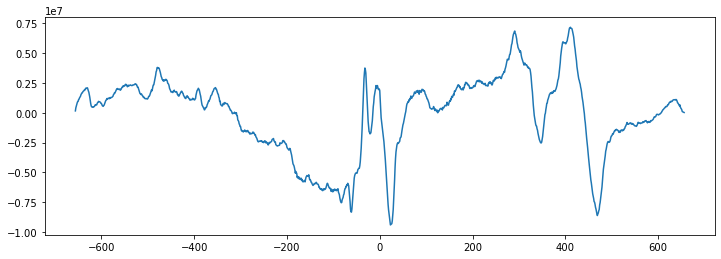

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jshifts, xcorr)
# ax.set(xlim=[-300, 300]);

That is a very clean result! One high narrow peak, at an offset of roughly 100, exactly where we expect it to be.

In [23]:
mm = (np.abs(jshifts) < 110) & (np.abs(jshifts) > 5)
jshift_peak = jshifts[mm][xcorr[mm].argmax()]
jshift_peak

-32

That is much better, at least for this example.

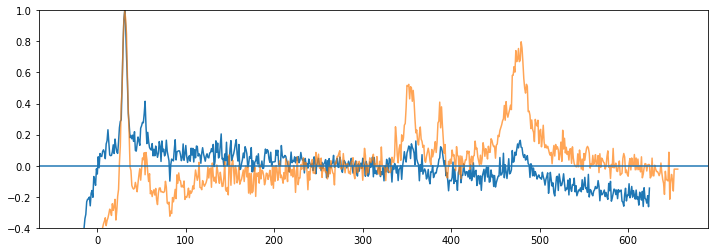

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit + jshift_peak, imslit_profile / np.max(imslit_profile))
ax.plot(jslit, spec_profile / np.max(spec_profile), alpha=0.7)
ax.set(yscale="linear", ylim=[-0.4, 1])
ax.axhline(0)

In [25]:
jwin_slice = slice(*db["jwin"])
jwin_slice_shift = slice(
    jwin_slice.start - jshift_peak,
    jwin_slice.stop - jshift_peak,
)

[None]

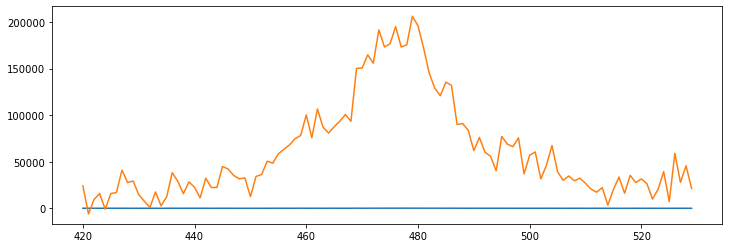

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit[jwin_slice], imslit_profile[jwin_slice_shift])
ax.plot(jslit[jwin_slice], 100 * spec_profile[jwin_slice])
ax.set(
    yscale="linear",
    #    ylim=[0, 1000]
)

We need to find the alignment along the slit.  Just use the initial guess for now.

In [27]:
j0_s = np.average(jslit[jwin_slice], weights=spec_profile[jwin_slice])
j0_i = np.average(
    jslit[jwin_slice_shift], weights=(10 + imslit_profile[jwin_slice_shift])
)
db["shift"] = jshift_peak
j0_s, j0_i, db["shift"]

(477.1320414354069, 525.2197920235591, -32)

In [28]:
slit_coords = mes.find_slit_coords(db, im_hdu.header, spec_hdu.header)

iarr = [391. 391. 391. 391. 391. 391. 391.] jarr = [ 32. 132. 232. 332. 432. 532. 632.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58582183, 43.62348454), (318.58603754, 43.63810561),
     (318.58625335, 43.6527267 ), (318.58646926, 43.66734779),
     (318.58668528, 43.68196887), (318.58690141, 43.69658996),
     (318.58711764, 43.71121105)]>
Binning along slit: image = 3 spectrum = 3


In [29]:
slit_coords["Dec"].shape, jslit.shape

((657,), (657,))

In [30]:
calib_profile = mes.slit_profile(
    slit_coords["RA"],
    slit_coords["Dec"],
    photom.data,
    wphot,
    # r = slit_coords["ds"],
)

Plot the calibration profile (green) compared with the spec and imslit profiles:

[None, (-0.1, 0.1)]

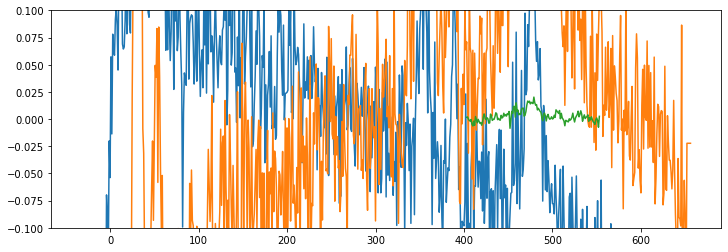

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit + db["shift"], imslit_profile / imslit_profile.max())
ax.plot(jslit, spec_profile / spec_profile.max())
ax.plot(jslit, 0.05 * calib_profile)
ax.set(yscale="linear", ylim=[-0.1, 0.1])

This is now working fine after I fixed the pixel scale in the calibration image.

We have the ability to look at the profiles at neighboring slit positions in the calibration image. This allows us to see if we might have an error in the `islit` value:

In [32]:
neighbors = [-2, -1, 1, 2]
nb_calib_profiles = {}
for nb in neighbors:
    nbdb = db.copy()
    nbdb["islit"] += nb
    nb_slit_coords = mes.find_slit_coords(nbdb, im_hdu.header, spec_hdu.header)
    nb_calib_profiles[nb] = mes.slit_profile(
        nb_slit_coords["RA"],
        nb_slit_coords["Dec"],
        photom.data,
        wphot,
        # nb_slit_coords["ds"],
    )

iarr = [389. 389. 389. 389. 389. 389. 389.] jarr = [ 32. 132. 232. 332. 432. 532. 632.]
coords =

 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58622579, 43.62348141), (318.58644159, 43.63810249),
     (318.5866575 , 43.65272357), (318.58687351, 43.66734466),
     (318.58708963, 43.68196575), (318.58730586, 43.69658684),
     (318.58752219, 43.71120792)]>
Binning along slit: image = 3 spectrum = 3
iarr = [390. 390. 390. 390. 390. 390. 390.] jarr = [ 32. 132. 232. 332. 432. 532. 632.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58602381, 43.62348298), (318.58623957, 43.63810405),
     (318.58645542, 43.65272514), (318.58667139, 43.66734622),
     (318.58688746, 43.68196731), (318.58710363, 43.6965884 ),
     (318.58731991, 43.71120949)]>
Binning along slit: image = 3 spectrum = 3
iarr = [392. 392. 392. 392. 392. 392. 392.] jarr = [ 32. 132. 232. 332. 432. 532. 632.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58561985, 43.6234861 ), (318.58583551, 43.63810718),
     (318.58605127, 43.65272826), (318.58626713, 43.667349

[None]

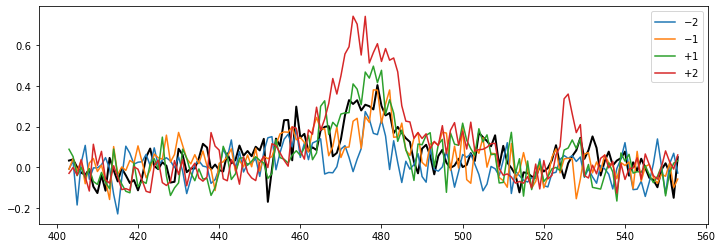

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(jslit + db["shift"], (imslit_profile + 20) * 10)
# ax.plot(jslit, spec_profile)
ax.plot(jslit, calib_profile, color="k", lw=2)
for nb in neighbors:
    ax.plot(jslit, nb_calib_profiles[nb], label=f"${nb:+d}$")
ax.legend()
ax.set(yscale="linear")

In [34]:
slit_points = (np.arange(len(spec_profile)) - j0_s) * slit_coords["ds"]

In [35]:
jslice0 = slice(int(j0_s) - 20, int(j0_s) + 20)

In [36]:
rat0 = np.nansum(spec_profile[jslice0]) / np.nansum(calib_profile[jslice0])
print("Coarse calibration: ratio =", rat0)

Coarse calibration: ratio = 6893.896364215066


In [37]:
spec_profile[jslice0]

array([ 679.80237,  746.90173,  781.5188 , 1002.0281 ,  756.88074,
       1065.7875 ,  869.7938 ,  807.3783 ,  875.6979 ,  933.693  ,
       1006.28455,  933.7328 , 1502.5555 , 1504.8319 , 1647.9592 ,
       1557.5479 , 1915.3535 , 1731.9065 , 1766.4529 , 1950.283  ,
       1731.5695 , 1755.9691 , 2061.9749 , 1960.5881 , 1722.7239 ,
       1453.839  , 1291.1094 , 1207.9839 , 1354.6711 , 1319.2794 ,
        900.07104,  908.94495,  837.74744,  617.84937,  760.9602 ,
        601.8191 ,  558.70264,  401.38712,  770.51855,  688.44946],
      dtype=float32)

In [38]:
calib_profile[jslice0]

array([ 0.23299869,  0.03469035,  0.29833066,  0.1462688 ,  0.16469303,
        0.07888099,  0.09855012,  0.08513406,  0.18157786,  0.19891075,
        0.20238252,  0.05437197,  0.07125995,  0.13823745,  0.25564438,
        0.33037529,  0.31143825,  0.32973769,  0.2797514 ,  0.3077331 ,
        0.30048363,  0.2847688 ,  0.40413197,  0.30209227,  0.25523744,
        0.26703487,  0.1683944 ,  0.19873811,  0.16929479,  0.14320469,
        0.12523165,  0.02767412, -0.02928926,  0.09224026,  0.11085001,
        0.05759842, -0.03421385,  0.05574899,  0.08637682,  0.0227256 ])

In [39]:
spec_profile /= rat0

In [40]:
figpath = Path.cwd().parent / "figs"
figpath.mkdir(exist_ok=True)

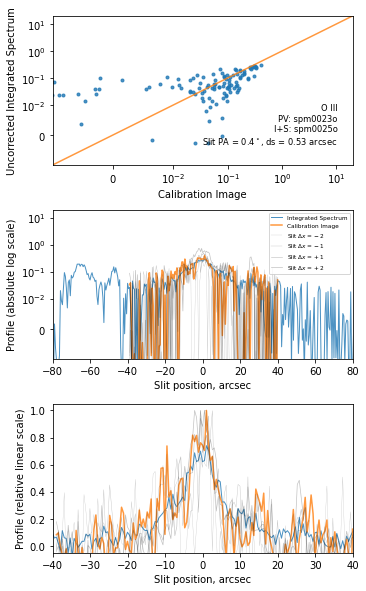

In [41]:
plt_prefix = figpath / f"{db['slit_id']}-calib"
mes.make_three_plots(
    spec_profile,
    calib_profile,
    plt_prefix,
    slit_points=slit_points,
    neighbors=nb_calib_profiles,
    db=db,
    sdb=slit_coords,
    return_fig=True,
);

## Now try the automated way

In [42]:
for db in slit_db_list:
    print(db)
    spec_hdu = fits.open(dpath / "originals" / db["orig_file"])[0]
    (im_hdu,) = fits.open(dpath / "wcs" / f"cr{db['image_id']}_b-wcs.fits")
    if db["slit_id"].startswith("N"):
        db["wa"] = 2
        db["ij"] = 2
    else:
        db["wa"] = 1
        db["ij"] = 1
    db["s"] = 1

    mes.pv_extract(
        spec_hdu,
        im_hdu,
        photom,
        db,
        restwavs,
        pvpath,
        neighbors=[-1, 1],
    )

{'slit_id': 'N10039', 'orig_file': 'crN10039_bx-oiii.fits', 'image_id': 'N10035', 'line_id': 'O III', 'slit_width': 70, 'islit': 442, 'jwin': [400, 600], 'comment': 'Just E of center.  Highest resolution for the inner shell. Image is Ha, not O III. '}
442
Shift along slit: 105
iarr = [-105.   -5.   95.  195.  295.  395.  495.  595.  695.  795.] jarr = [441. 441. 441. 441. 441. 441. 441. 441. 441. 441.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58462271, 43.64527184), (318.5845694 , 43.65500889),
     (318.58451607, 43.66474594), (318.58446273, 43.67448299),
     (318.58440936, 43.68422005), (318.58435598, 43.6939571 ),
     (318.58430258, 43.70369415), (318.58424917, 43.7134312 ),
     (318.58419573, 43.72316825), (318.58414228, 43.7329053 )]>
Binning along slit: image = 2 spectrum = 2
iarr = [-105.   -5.   95.  195.  295.  395.  495.  595.  695.  795.] jarr = [440. 440. 440. 440. 440. 440. 440. 440. 440. 440.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, d

Wav: [5001.84, 5003.34] Pixel: [236.9843552  271.79879729]
Wav: [5010.34, 5011.84] Pixel: [434.26619371 469.0806358 ]
Background weights: 34930 34930
Wav: [5001.84, 5011.84] Pixel: [236.9843552 469.0806358]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58461399, 43.64526629), (318.58456064, 43.65500334),
     (318.58450726, 43.66474039), (318.58445387, 43.67447743),
     (318.58440047, 43.68421448), (318.58434704, 43.69395152),
     (318.5842936 , 43.70368856), (318.58424014, 43.71342559),
     (318.58418666, 43.72316263), (318.58413317, 43.73289965)]>
Displacements in arcsec: [0.         0.00011235 0.00022518 0.00033893 0.00045408 0.00057107
 0.00069035 0.00081233 0.00093742 0.00106601]
Wav: [5010.68, 5012.18] Pixel: [442.15746725 476.97190935]
Wav: [5019.18, 5020.68] Pixel: [639.43930577 674.25374786]
Background weights: 34930 34930
Wav: [5010.68, 5020.68] Pixel: [442.15746725 674.25374786]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58461399, 43.64526629), (3

Wav: [5001.84, 5003.34] Pixel: [235.44281788 270.26057145]
Wav: [5010.34, 5011.84] Pixel: [432.74342143 467.561175  ]
Background weights: 34930 34930
Wav: [5001.84, 5011.84] Pixel: [235.44281788 467.561175  ]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58563865, 43.64509108), (318.58559176, 43.65483004),
     (318.58554486, 43.664569  ), (318.58549794, 43.67430796),
     (318.58545101, 43.68404692), (318.58540406, 43.69378587),
     (318.58535709, 43.70352483), (318.58531011, 43.71326378),
     (318.58526312, 43.72300272), (318.58521611, 43.73274166)]>
Displacements in arcsec: [0.00000000e+00 9.87739221e-05 1.98082217e-04 2.98458915e-04
 4.00428706e-04 5.04502417e-04 6.11172767e-04 7.20912595e-04
 8.34170384e-04 9.51369177e-04]
Wav: [5010.68, 5012.18] Pixel: [440.63544557 475.45319914]
Wav: [5019.18, 5020.68] Pixel: [637.93604912 672.75380269]
Background weights: 33932 34930
Wav: [5010.68, 5020.68] Pixel: [440.63544557 672.75380269]
New coords: <SkyCoord (ICRS): (ra, dec) 

coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58569644, 43.62946515), (318.58564254, 43.63920708),
     (318.58558863, 43.64894901), (318.58553469, 43.65869095),
     (318.58548074, 43.66843289), (318.58542677, 43.67817483),
     (318.58537279, 43.68791676), (318.58531878, 43.6976587 ),
     (318.58526476, 43.70740064), (318.58521072, 43.71714258)]>
Binning along slit: image = 2 spectrum = 2
iarr = [-90.  10. 110. 210. 310. 410. 510. 610. 710. 810.] jarr = [449. 449. 449. 449. 449. 449. 449. 449. 449. 449.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58542726, 43.62946437), (318.58537332, 43.6392063 ),
     (318.58531936, 43.64894823), (318.58526538, 43.65869017),
     (318.58521139, 43.66843211), (318.58515737, 43.67817405),
     (318.58510334, 43.68791598), (318.5850493 , 43.69765792),
     (318.58499523, 43.70739986), (318.58494115, 43.71714179)]>
Binning along slit: image = 2 spectrum = 2
Normalizations: 14.134323 39.771342514744134
[

Wav: [5001.84, 5003.34] Pixel: [230.86643782 265.65894976]
Wav: [5010.34, 5011.84] Pixel: [428.02400548 462.81651742]
Background weights: 34930 34930
Wav: [5001.84, 5011.84] Pixel: [230.86643782 462.81651742]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58555313, 43.62945921), (318.58549917, 43.63920114),
     (318.58544519, 43.64894307), (318.58539119, 43.65868499),
     (318.58533717, 43.66842692), (318.58528313, 43.67816884),
     (318.58522908, 43.68791077), (318.58517501, 43.69765268),
     (318.58512092, 43.7073946 ), (318.58506682, 43.71713651)]>
Displacements in arcsec: [0.         0.00011372 0.00022825 0.0003444  0.00046297 0.00058471
 0.00071035 0.00084059 0.00097606 0.00111737]
Wav: [5010.68, 5012.18] Pixel: [435.91030819 470.70282013]
Wav: [5019.18, 5020.68] Pixel: [633.06787585 667.86038779]
Background weights: 34930 34930
Wav: [5010.68, 5020.68] Pixel: [435.91030819 667.86038779]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58555313, 43.62945921), 

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Wav: [5001.84, 5003.34] Pixel: [174.39892417 197.69526892]
Wav: [5010.34, 5011.84] Pixel: [306.41154443 329.70788918]
Background weights: 15768 15768
Wav: [5001.84, 5011.84] Pixel: [174.39892417 329.70788918]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58581311, 43.62347898), (318.58602899, 43.63810006),
     (318.58624497, 43.65272113), (318.58646105, 43.66734219),
     (318.58667724, 43.68196325), (318.58689354, 43.69658431),
     (318.58710994, 43.71120535)]>
Displacements in arcsec: [0.         0.00044862 0.00089859 0.00135128 0.00180803 0.00227017
 0.002739  ]
Wav: [5010.68, 5012.18] Pixel: [311.69204924 334.98839399]
Wav: [5019.18, 5020.68] Pixel: [443.70466949 467.00101424]
Background weights: 15111 15111
Wav: [5010.68, 5020.68] Pixel: [311.69204924 467.00101424]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58581311, 43.62347898), (318.58602899, 43.63810006),
     (318.58624497, 43.65272113), (318.58646105, 43.66734219),
     (318.58667724, 43.68196325),

Wav: [5001.84, 5003.34] Pixel: [174.98167925 198.25467017]
Wav: [5010.34, 5011.84] Pixel: [306.86196113 330.13495205]
Background weights: 15065 15065
Wav: [5001.84, 5011.84] Pixel: [174.98167925 330.13495205]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58398767, 43.64719165), (318.58418631, 43.66180104),
     (318.58438506, 43.67641044), (318.5845839 , 43.69101983),
     (318.58478283, 43.70562921), (318.58498186, 43.72023858),
     (318.58518099, 43.73484795)]>
Displacements in arcsec: [0.         0.00041128 0.00082311 0.00123605 0.00165064 0.00206744
 0.00248699]
Wav: [5010.68, 5012.18] Pixel: [312.13717241 335.41016333]
Wav: [5019.18, 5020.68] Pixel: [444.01745429 467.29044521]
Background weights: 15065 15065
Wav: [5010.68, 5020.68] Pixel: [312.13717241 467.29044521]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58398767, 43.64719165), (318.58418631, 43.66180104),
     (318.58438506, 43.67641044), (318.5845839 , 43.69101983),
     (318.58478283, 43.70562921),

Wav: [5001.84, 5003.34] Pixel: [174.81093918 198.08843186]
Wav: [5010.34, 5011.84] Pixel: [306.71673108 329.99422377]
Background weights: 15065 15065
Wav: [5001.84, 5011.84] Pixel: [174.81093918 329.99422377]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58282448, 43.64666291), (318.58301904, 43.66127617),
     (318.58321369, 43.67588944), (318.58340844, 43.6905027 ),
     (318.58360328, 43.70511596), (318.58379822, 43.71972921),
     (318.58399325, 43.73434244)]>
Displacements in arcsec: [0.         0.00040294 0.00080652 0.0012114  0.00161822 0.00202761
 0.00244021]
Wav: [5010.68, 5012.18] Pixel: [311.99296276 335.27045545]
Wav: [5019.18, 5020.68] Pixel: [443.89875467 467.17624736]
Background weights: 15065 15065
Wav: [5010.68, 5020.68] Pixel: [311.99296276 467.17624736]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58282448, 43.64666291), (318.58301904, 43.66127617),
     (318.58321369, 43.67588944), (318.58340844, 43.6905027 ),
     (318.58360328, 43.70511596),

In [43]:
db

{'slit_id': 'spm0107o',
 'orig_file': 'crspm0107o_bx.fits',
 'image_id': 'spm0109o',
 'line_id': 'O III',
 'slit_width': 150,
 'islit': 363,
 'jwin': [310, 430],
 'comment': 'W of center. Shows outer lobes well. Shows central blue wing.',
 'wa': 1,
 'ij': 1,
 's': 1,
 'shift': 69}